# Training

In [1]:
import torch
import random
import numpy as np

# from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import json

from matplotlib import pyplot as plt

from ipynb.fs.full.read_in_data import read_in_data

from transforms import train_transforms, val_transforms
from dataset import ContrastiveLearningDataset, SimpleDataset

## Loading data

In [2]:
with open("../public_dataset/reference_images_part1.json") as f:
    ref_json = json.load(f)

dir_str = "../public_dataset/reference_images_part1"
df = read_in_data(dir_str, ref_json)

df = df.sort_values('category_id')
df = df.reset_index(drop=True)
df.head()

,id,image_id,bbox,category_id,img
0,155,33,"[116, 97, 411, 126]",1,<PIL.Image.Image image mode=RGB size=411x126 a...
1,33,6,"[573, 246, 164, 298]",1,<PIL.Image.Image image mode=RGB size=164x298 a...
2,32,6,"[114, 269, 363, 223]",1,<PIL.Image.Image image mode=RGB size=363x223 a...
3,30,6,"[622, 218, 374, 220]",1,<PIL.Image.Image image mode=RGB size=374x220 a...
4,29,6,"[743, 486, 354, 132]",1,<PIL.Image.Image image mode=RGB size=354x132 a...


In [3]:
from torchvision.transforms import transforms as T

1
torch.Size([3, 224, 224])


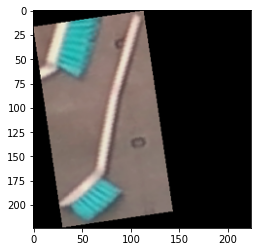

In [4]:
id = 1
img = df['img'][id]
print(df['category_id'][id])

img = train_transforms(img)

print(img.shape)

plt.imshow(img.permute(1, 2, 0))

In [5]:
images = df['img']
labels = df['category_id']

val_labels = [4, 10]
val_ids = ~labels.isin(val_labels) # TODO

val_images = images[val_ids].reset_index(drop=True)
val_labels = labels[val_ids].reset_index(drop=True)

train_ids = ~val_ids

train_images = images[train_ids].reset_index(drop=True)
train_labels = labels[train_ids].reset_index(drop=True)

In [6]:
train_dataset = ContrastiveLearningDataset(train_images, train_labels, train_transforms)
val_dataset = SimpleDataset(train_images, train_labels, val_transforms)

In [7]:
id_ = random.randrange(0, len(train_dataset))

image_1, image_2, sign, weight = train_dataset[id_]

# f, axarr = plt.subplots(1,2) 

# axarr[0].imshow(image_1.permute(1, 2, 0))
# axarr[1].imshow(image_2.permute(1, 2, 0))

# sign, weight

print(image_1.mean(), image_1.max(), image_1.min())

tensor(0.2204) tensor(1.) tensor(0.)


In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


In [9]:
BATCH_SIZE = 12

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True,
)

## Training loop

In [10]:
EPOCHS = 10

In [11]:
from model import ImageEmbeddingModel

In [12]:
out_dim=32

model = ImageEmbeddingModel(out_dim=out_dim, efficientnet_model_name="efficientnet-b0").to(device=DEVICE)
optimizer = torch.optim.Adam(model.get_last_params())

Loaded pretrained weights for efficientnet-b0


In [13]:
from losses import ContrastiveLoss, CosineSimilarityLoss

# loss_function = CosineSimilarityLoss()
loss_function = ContrastiveLoss(np.sqrt(out_dim))
loss_function2 = ContrastiveLoss(np.sqrt(out_dim), reduction="NONE")
# cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

# def contrastive_learning_loss(v_1, v_2, weight, sign):
#     cos_sim = cos(v_1, v_2)
#     loss = - weight * cos_sim * sign
#     return loss.mean()



In [14]:
from sklearn.decomposition import PCA

def validate(model, dataset):
    embeddings = []
    labels = []
    for i in range(len(dataset)):
        image, label = dataset[i]
        image = image.to(device=DEVICE).unsqueeze(0)
        label = label
        emb = model(image)
        embeddings.append(emb[0].detach().cpu().numpy())
        labels.append(label)

    emb4lab_dict = {}
    for e, l in zip(embeddings, labels):
        if l not in emb4lab_dict.keys():
            emb4lab_dict[l] = [e]
        else:
            emb4lab_dict[l].append(e)
    for l in emb4lab_dict.keys():
        emb4lab_dict[l] = np.mean(np.array(emb4lab_dict[l]), axis=0)
    
    lbl_dsts = {}
    for e, l in zip(embeddings, labels):
        dst = np.sum(np.abs(e - emb4lab_dict[l]))
        if l not in lbl_dsts.keys():
            lbl_dsts[l] = [dst]
        else:
            lbl_dsts[l].append(dst)
    for l in lbl_dsts.keys():
        lbl_dsts[l] = np.mean(np.array(lbl_dsts[l]), axis=0)
        print(f"LABEL: {l} - MEAN DST: {lbl_dsts[l]}")
    
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    
    pca = PCA()
    pca.fit(embeddings)
    emb2d = pca.transform(embeddings)
    plt.scatter(emb2d[:,0], emb2d[:,1], c=labels)
    plt.show()

LABEL: 4 - MEAN DST: 3.849400758743286
LABEL: 10 - MEAN DST: 3.877608299255371


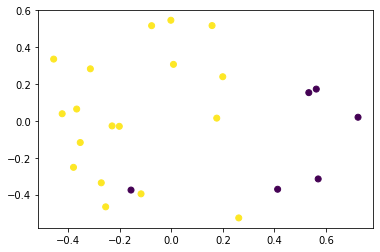

tensor([-1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1], device='cuda:0')
tensor([0.2222, 0.0741, 0.2222, 0.0741, 0.0741, 0.0741, 0.0741, 0.0741, 0.6667,
        0.2222, 0.6667, 0.0741], device='cuda:0', dtype=torch.float64)
tensor([4.3728, 0.1256, 4.1030, 0.1413, 0.0877, 0.0972, 0.1086, 0.1650, 0.9422,
        3.9992, 0.7284, 0.0903], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
i: 0: 1.2467830306217993
tensor([-1, -1, -1,  1, -1,  1,  1,  1, -1,  1, -1, -1], device='cuda:0')
tensor([0.2222, 0.2222, 0.2222, 0.0741, 0.2222, 0.0741, 0.0741, 0.0741, 0.2222,
        0.6667, 0.2222, 0.2222], device='cuda:0', dtype=torch.float64)
tensor([5.0273, 3.9529, 4.4391, 0.0186, 4.8692, 0.0084, 0.0117, 0.0149, 3.9678,
        0.3548, 4.3983, 4.1394], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1], device='cuda:0')
tensor([0.0741, 0.0741, 0.6667, 0.0741, 0.6667, 0.0741, 0.0741, 0.0741, 0.0741,
       

KeyboardInterrupt: 

In [15]:
validate(model, val_dataset)
for epoch in range(EPOCHS):
    if epoch == 3:
        optimizer = torch.optim.Adam(model.get_backbone_params())
    losses = []
    for i, data in enumerate(train_loader, 0):
        image_1, image_2, sign, weight = data
        image_1 = image_1.to(device=DEVICE)
        image_2 = image_2.to(device=DEVICE)
        sign = sign.to(device=DEVICE)
        weight = None # weight.to(device=DEVICE)

        v_1 = model(image_1)
        v_2 = model(image_2)
        
        loss = loss_function(v_1, v_2, sign, weight=weight)
        loss2 = loss_function2(v_1, v_2, sign, weight=weight)
        
        print(sign)
        print(weight)
        print(loss2)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().item())
        if i % 10 == 0:
            print(f"i: {i}: {loss}")
        
    total_loss = np.mean(losses)
    print(f"Epoch: {epoch + 1}/{EPOCHS}: Loss: {total_loss}")
    validate(model, val_dataset)
        # YOUR CODE HERE
        
        # TODO: walidacja, wypisywanie lossów itd
        # END YOUR CODE